### Part A
1. Are the crimes clustered? Is there Central Tendency? Create a density map showing the local
density (quadrat or kernel method may be used) and describe the results (< 100 words).
2. Are there spatial outliers or trends in the data you’ve selected? Discuss (include any tests run,
figures, and maps generated) (200 - 400 words).

In [57]:
# import all required libararies 
import requests
import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import warnings
from pointpats import centrography
import esda
import libpysal as lib
import contextily
import splot
from splot.esda import plot_moran

from shapely.geometry import Point

warnings.filterwarnings('ignore')

In [2]:
# Extract Robbery crime data 
# uisng the robbery crime data APi from https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/api
url = "
# set the parameters and use a while loop to use to extract the dataset since ArcGIS rest API has a limit of loading 1000 once
offset = 0
batch_size = 1000
total_records = 40000
features = []

while offset < total_records:
    query_url = url + f"&resultOffset={offset}&resultRecordCount={batch_size}"
    response = requests.get(query_url)
    data = response.json()
    features.extend(data['features'])
    offset += batch_size

# print the feature count
print(len(features))

# Rey, S. J., & Anselin, L. (2021). Point pattern analysis. Geographic Data Science, Chapter 8. Retrieved from https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html

29230


In [3]:
# use pandas to convert the json object feature dataset extracted to a dataframe
df = pd.json_normalize(features)
df.head()

,type,id,geometry.type,geometry.coordinates,properties.OBJECTID,properties.event_unique_id,properties.Division,properties.occurrencedate,properties.reporteddate,properties.location_type,...,properties.occurrenceday,properties.occurrencedayofyear,properties.occurrencedayofweek,properties.occurrencehour,properties.mci_category,properties.Hood_ID,properties.Neighbourhood,properties.Longitude,properties.Latitude,properties.ObjectId2
0,Feature,1,Point,"[-79.42879592, 43.78305981]",4776,GO-20141621901,D32,1393650000000,1393650000000,Schools During Un-Supervised Activity,...,1.0,60.0,Saturday,16,Robbery,36,Newtonbrook West,-79.428796,43.783060,1
1,Feature,2,Point,"[-79.33727518, 43.68042137]",4777,GO-20141620235,D54,1393650000000,1393650000000,"Streets, Roads, Highways (Bicycle Path, Privat...",...,1.0,60.0,Saturday,6,Robbery,66,Danforth,-79.337275,43.680421,2
2,Feature,3,Point,"[-79.55947089, 43.75074185]",4781,GO-20141621683,D31,1393650000000,1393650000000,"Apartment (Rooming House, Condo)",...,1.0,60.0,Saturday,15,Robbery,21,Humber Summit,-79.559471,43.750742,3
3,Feature,4,Point,"[-79.44063201, 43.72782912]",4793,GO-20141623026,D32,1393650000000,1393650000000,"Open Areas (Lakes, Parks, Rivers)",...,1.0,60.0,Saturday,20,Robbery,32,Englemount-Lawrence,-79.440632,43.727829,4
4,Feature,5,Point,"[-79.25089301, 43.7544141]",4794,GO-20141623316,D43,1393650000000,1393650000000,"Streets, Roads, Highways (Bicycle Path, Privat...",...,1.0,60.0,Saturday,21,Robbery,127,Bendale,-79.250893,43.754414,5


In [4]:
len(df)

29230

In [5]:
# check the columns
df.columns

Index(['type', 'id', 'geometry.type', 'geometry.coordinates',
       'properties.OBJECTID', 'properties.event_unique_id',
       'properties.Division', 'properties.occurrencedate',
       'properties.reporteddate', 'properties.location_type',
       'properties.premises_type', 'properties.ucr_code', 'properties.ucr_ext',
       'properties.offence', 'properties.reportedyear',
       'properties.reportedmonth', 'properties.reportedday',
       'properties.reporteddayofyear', 'properties.reporteddayofweek',
       'properties.reportedhour', 'properties.occurrenceyear',
       'properties.occurrencemonth', 'properties.occurrenceday',
       'properties.occurrencedayofyear', 'properties.occurrencedayofweek',
       'properties.occurrencehour', 'properties.mci_category',
       'properties.Hood_ID', 'properties.Neighbourhood',
       'properties.Longitude', 'properties.Latitude', 'properties.ObjectId2'],
      dtype='object')

In [7]:
# llok at the year range of the robbery data extracted
df["properties.reportedyear"].max(), df["properties.reportedyear"].min()

(2022, 2014)

In [8]:
# extract all the useful columns from the dataset
robbery_df = df[['properties.location_type','geometry.coordinates',
       'properties.premises_type', 'properties.offence', 'properties.reportedyear',
       'properties.reportedmonth', 'properties.Latitude','properties.Longitude']]

robbery_df.head()

,properties.location_type,geometry.coordinates,properties.premises_type,properties.offence,properties.reportedyear,properties.reportedmonth,properties.Latitude,properties.Longitude
0,Schools During Un-Supervised Activity,"[-79.42879592, 43.78305981]",Educational,Robbery - Swarming,2014,March,43.783060,-79.428796
1,"Streets, Roads, Highways (Bicycle Path, Privat...","[-79.33727518, 43.68042137]",Outside,Robbery - Mugging,2014,March,43.680421,-79.337275
2,"Apartment (Rooming House, Condo)","[-79.55947089, 43.75074185]",Apartment,Robbery - Purse Snatch,2014,March,43.750742,-79.559471
3,"Open Areas (Lakes, Parks, Rivers)","[-79.44063201, 43.72782912]",Outside,Robbery - Mugging,2014,March,43.727829,-79.440632
4,"Streets, Roads, Highways (Bicycle Path, Privat...","[-79.25089301, 43.7544141]",Outside,Robbery - Purse Snatch,2014,March,43.754414,-79.250893


In [9]:
# standardize the columns name
robbery_df.rename(columns={'properties.location_type':'location_type',
                           'geometry.coordinates':'coordinates',
       'properties.premises_type':'premises_type', 'properties.offence':'offence', 
                          'properties.reportedyear':'reportedyear',
       'properties.reportedmonth':'reportedmonth', 'properties.Latitude':'Latitude',
                          'properties.Longitude':'Longitude'}, inplace=True)
robbery_df.head()

,location_type,coordinates,premises_type,offence,reportedyear,reportedmonth,Latitude,Longitude
0,Schools During Un-Supervised Activity,"[-79.42879592, 43.78305981]",Educational,Robbery - Swarming,2014,March,43.783060,-79.428796
1,"Streets, Roads, Highways (Bicycle Path, Privat...","[-79.33727518, 43.68042137]",Outside,Robbery - Mugging,2014,March,43.680421,-79.337275
2,"Apartment (Rooming House, Condo)","[-79.55947089, 43.75074185]",Apartment,Robbery - Purse Snatch,2014,March,43.750742,-79.559471
3,"Open Areas (Lakes, Parks, Rivers)","[-79.44063201, 43.72782912]",Outside,Robbery - Mugging,2014,March,43.727829,-79.440632
4,"Streets, Roads, Highways (Bicycle Path, Privat...","[-79.25089301, 43.7544141]",Outside,Robbery - Purse Snatch,2014,March,43.754414,-79.250893


In [10]:
# convert the dataframe to a geodataframe
# Convert latitude and longitude to Point geometry
robbery_gdf = gpd.GeoDataFrame(robbery_df,
                               geometry=gpd.points_from_xy(robbery_df.Longitude, robbery_df.Latitude))

# Set coordinate reference system (CRS)
robbery_gdf.crs = 'epsg:4326'
type(robbery_gdf)

geopandas.geodataframe.GeoDataFrame

In [11]:
# select all robbery crime data for 2016 that has coordinates
robbery_gdf2 = robbery_gdf[(robbery_gdf['Latitude'] > 0) & (robbery_gdf['reportedyear'] == 2016)]
len(robbery_gdf2)

3705

In [18]:
# check the months the data where reported for
# month data were reported
robbery_gdf2["reportedmonth"].value_counts()

July         360
June         332
November     331
October      329
August       325
April        313
May          311
February     295
September    294
December     275
March        274
January      266
Name: reportedmonth, dtype: int64

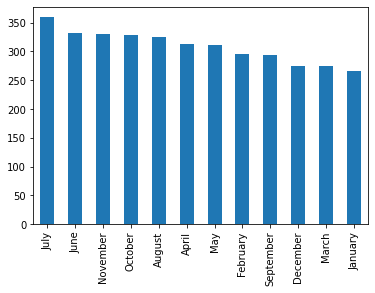

In [19]:
# check the months the data where reported for
# month data were reported
robbery_gdf2["reportedmonth"].value_counts().plot(kind='bar');

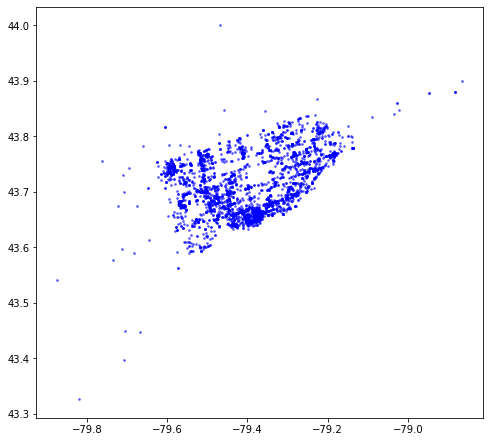

In [21]:
fig, ax = plt.subplots(figsize=(8,9))
# ax.set_aspect('equal')
robbery_gdf2.plot(ax=ax, alpha=0.5, color='blue', markersize=3);

In Toronto, robbery crimes were recorded in 2016 with a total of 3705 incidents. The month with the highest number of robberies was July, accounting for 360 incidents, while the least amount of robberies occurred in January with only 266 incidents.

#### 1. Are the crimes clustered? Is there Central Tendency? Create a density map showing the local density (quadrat or kernel method may be used) and describe the results (< 100 words).

In [37]:
# Find the mean and median center of the spatial dataset to measure the central tendency
mean_center = centrography.mean_center(robbery_gdf2[["Longitude","Latitude"]])
med_center = centrography.euclidean_median(robbery_gdf2[["Longitude","Latitude"]])
print(f"The mean center is : {mean_center}")
print(f"The median center is: {med_center}")



The mean center is : [-79.39976751  43.71014919]
The median center is: [-79.40044105  43.69140378]


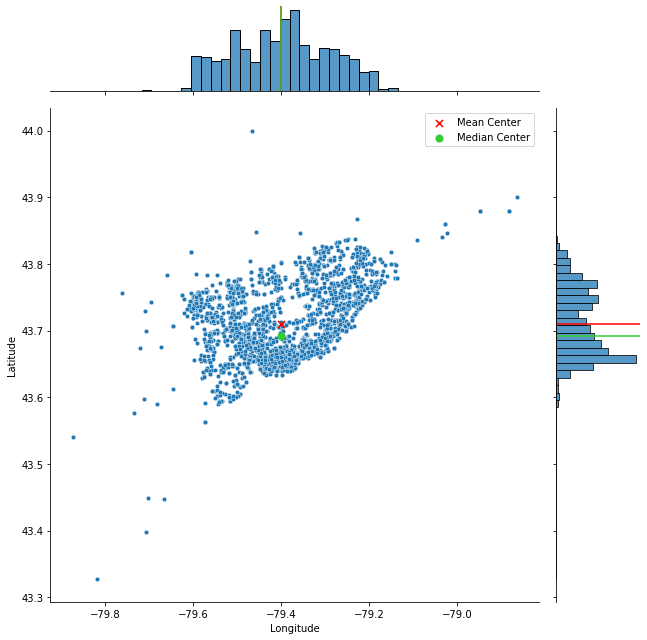

In [46]:
# Dispaly the mean and median value on a plot
# Generate scatter plot
joint_axes = sns.jointplot(
    robbery_gdf2,
    x="Longitude",
    y="Latitude",
    s=20, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")

# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")

#Legend
joint_axes.ax_joint.legend()


# Clean axes
# joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

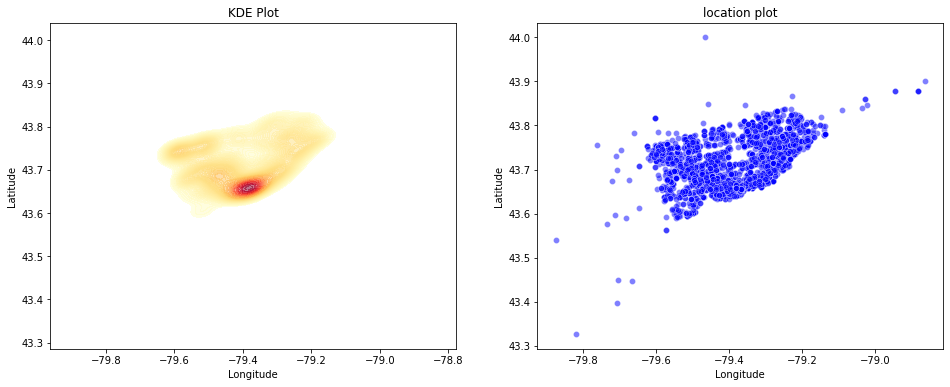

In [47]:
# plot the kernel density map
# Set up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Generate and add the KDE plot to the first axis
sns.kdeplot(
    data=robbery_gdf2,
    x="Longitude",
    y="Latitude",
    n_levels=75,
    shade=True,
    fill=True,
    levels=90,
    alpha=0.55,
    linewidths=1.5,
    cmap="YlOrRd",
    ax=axs[0]
)

# Generate and add the scatter plot to the second axis
sns.scatterplot(
    data=robbery_gdf2,
    x="Longitude",
    y="Latitude",
    alpha=0.5,
    color='blue',
    ax=axs[1]
)

# Set titles for the plots
axs[0].set_title("KDE Plot")
axs[1].set_title("location plot")



# Display the plots
plt.show()


##### Findings
The kernel density maps of the crime occurrence in Toronto reveal that the crime density is higher in the southern part of the city, while there is little to no robbery crime incidence in central Toronto. The central tendency chart further illustrates that the mean and median of the data distribution are around the southern part of the study area, indicating a high concentration of robbery crime incidents in that region. These results suggest that the southern part of Toronto is more prone to robbery crimes, while the central part of the city is relatively safer. Such insights can help law enforcement agencies and policymakers to target their crime prevention efforts more effectively, such as by increasing police patrols and improving the lighting and security measures in high-risk areas.

###### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Are there spatial outliers or trends in the data you’ve selected? Discuss (include any tests run,
figures, and maps generated) (200 - 400 words)

In [86]:
#load dataset
robbery_gdf2.head()

,location_type,coordinates,premises_type,offence,reportedyear,reportedmonth,Latitude,Longitude,geometry
7040,Schools During Un-Supervised Activity,"[-79.48210041, 43.68063272]",Educational,Robbery - Mugging,2016,February,43.680633,-79.482100,POINT (-79.48210 43.68063)
7101,Bank And Other Financial Institutions (Money M...,"[-79.14087514, 43.78965739]",Commercial,Robbery - Financial Institute,2016,March,43.789657,-79.140875,POINT (-79.14088 43.78966)
7104,"Commercial Dwelling Unit (Hotel, Motel, B & B,...","[-79.37592197, 43.64958517]",Commercial,Robbery With Weapon,2016,January,43.649585,-79.375922,POINT (-79.37592 43.64959)
7105,"Gas Station (Self, Full, Attached Convenience)","[-79.18877904, 43.76850527]",Commercial,Robbery - Business,2016,February,43.768505,-79.188779,POINT (-79.18878 43.76851)
7106,"Streets, Roads, Highways (Bicycle Path, Privat...","[-79.59190438, 43.74533099]",Outside,Robbery With Weapon,2016,January,43.745331,-79.591904,POINT (-79.59190 43.74533)


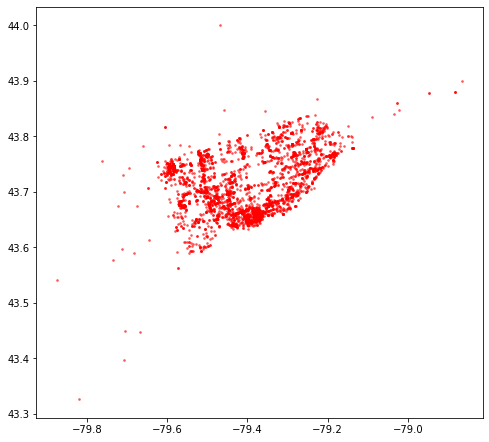

In [89]:
# Visualize the data using scatter plot to visually see outliers
fig, ax = plt.subplots(figsize=(8,9))
# ax.set_aspect('equal')
robbery_gdf2.plot(ax=ax, alpha=0.5, color='red', markersize=3);

In [241]:
# Create a spatial weights matrix based on the data's spatial coordinates
w = lib.weights.distance.KNN.from_dataframe(robbery_gdf2, k=10)

# Calculate Moran's I for the spatial coordinates
moran = esda.Moran(robbery_gdf2['Latitude'],w)

# Print the Moran's I statistic and p-value
print(f"Moran's I: {moran.I:.2f}")
print(f"p-value: {moran.p_sim:.3f}")

Moran's I: 0.96
p-value: 0.001


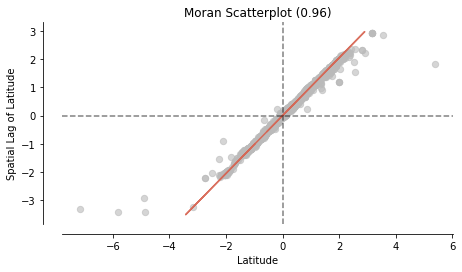

In [242]:
#moran I plot to identify outliers
fig, ax = splot.esda.moran_scatterplot(moran, p=0.001)
ax.set_xlabel('Latitude')
ax.set_ylabel('Spatial Lag of Latitude')
plt.show()

In [184]:
moran_2 = esda.moran.Moran_Local(robbery_gdf2['Latitude'], w)
print((moran_2.q))

[3 1 3 ... 3 3 3]


In [223]:
# We can distinguish the specific type of local spatial association 
# reflected in the four quadrants of the Moran Scatterplot above:
sig = 1 * (moran_2.p_sim < 0.05)

coldspot = 1 * (sig * moran_2.q==1)
doughnut = 2 * (sig * moran_2.q==2)
hotspot = 3 * (sig * moran_2.q==3)
diamond =  4 * (sig * moran_2.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 1, 3, ..., 3, 3, 3])

In [229]:
spot_labels = [ '0 ns', '1 cold spot', '3 cold spot', '4 hot spot']
labels = [spot_labels[i] for i in spots]

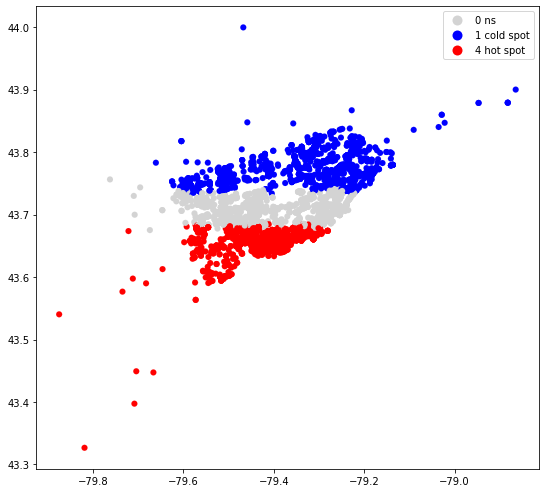

In [233]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'lightblue', 'blue', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
robbery_gdf2.assign(cl=labels).plot(column='cl', categorical=True, \
        k=5, cmap=hmap, linewidth=0.1, ax=ax, \
        legend=True)
plt.show()

##### Findings
The Moran's I test is commonly used in spatial analysis to detect the presence of spatial autocorrelation, or clustering, in the data. In the case of the robbery dataset, the Moran's I test is used to identify spatial outliers, which are areas that are significantly different from their surrounding areas in terms of the number of reported robberies.

The result of the Moran's I test for the robbery dataset shows a high positive correlation, indicating a significant level of spatial clustering in the data. This result suggests that areas with a high number of reported robberies are likely to be surrounded by other areas with a high number of reported robberies.

The Moran's I test also identifies spatial outliers, which are areas that deviate from the spatial pattern of the data. In the case of the robbery dataset, the test identifies areas with a significantly higher or lower number of reported robberies than would be expected based on the surrounding areas.

In the resulting map, the areas identified as spatial outliers are highlighted in blue (cold spots) or red (hot spots), indicating areas with a significantly lower or higher number of reported robberies, respectively. These areas could be further investigated to identify potential causes for the deviation in the spatial pattern of the data. For example, areas with a high number of reported robberies may have a higher concentration of businesses or other factors that make them more vulnerable to robbery. Conversely, areas with a lower number of reported robberies may have more security measures or fewer potential targets for robbery.

###### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Part B
3. What is the probability that this spatial pattern could have arisen by chance (Moran’s I)?
(Include graphs and or text to support your answer.)
4. What are some other factors that might influence the location of these types of crimes? Use
plots or graphs as necessary to support your response. (200 - 400 words) You might explore
data from the City of Toronto, https://www.toronto.ca/city-government/data-researchmaps/
open-data/, or datasets from other providers, e.g.: https://open.canada.ca/en

In [48]:
# view the dataset again
robbery_gdf2.head()

,location_type,coordinates,premises_type,offence,reportedyear,reportedmonth,Latitude,Longitude,geometry
7040,Schools During Un-Supervised Activity,"[-79.48210041, 43.68063272]",Educational,Robbery - Mugging,2016,February,43.680633,-79.482100,POINT (-79.48210 43.68063)
7101,Bank And Other Financial Institutions (Money M...,"[-79.14087514, 43.78965739]",Commercial,Robbery - Financial Institute,2016,March,43.789657,-79.140875,POINT (-79.14088 43.78966)
7104,"Commercial Dwelling Unit (Hotel, Motel, B & B,...","[-79.37592197, 43.64958517]",Commercial,Robbery With Weapon,2016,January,43.649585,-79.375922,POINT (-79.37592 43.64959)
7105,"Gas Station (Self, Full, Attached Convenience)","[-79.18877904, 43.76850527]",Commercial,Robbery - Business,2016,February,43.768505,-79.188779,POINT (-79.18878 43.76851)
7106,"Streets, Roads, Highways (Bicycle Path, Privat...","[-79.59190438, 43.74533099]",Outside,Robbery With Weapon,2016,January,43.745331,-79.591904,POINT (-79.59190 43.74533)


In [53]:
# Create a spatial weights matrix based on the data's spatial coordinates
w = lib.weights.distance.KNN.from_dataframe(robbery_gdf2, k=10)

# Calculate Moran's I for the spatial coordinates
moran = esda.Moran(robbery_gdf2['Latitude'],w)

# Print the Moran's I statistic and p-value
print(f"Moran's I: {moran.I:.2f}")
print(f"p-value: {moran.p_sim:.3f}")

Moran's I: 0.96
p-value: 0.001


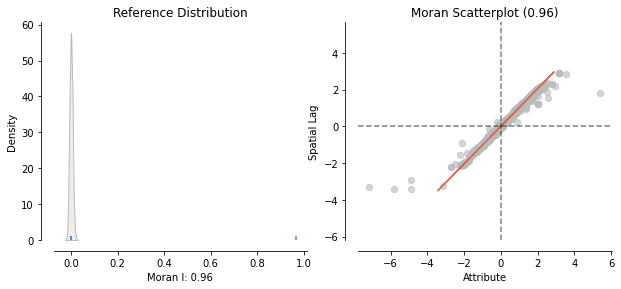

In [54]:
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

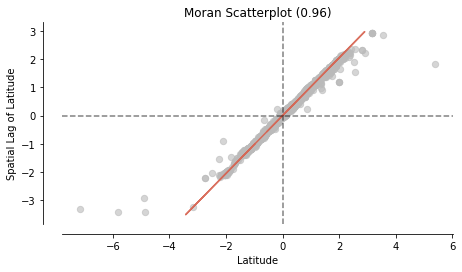

In [90]:
#build a moran I sccatter plot to show spatial lag of the dataset using
fig, ax = splot.esda.moran_scatterplot(moran, p=0.001)
ax.set_xlabel('Latitude')
ax.set_ylabel('Spatial Lag of Latitude')
plt.show()

#### Findings
The Toronto robbery crime data exhibit a high level of spatial autocorrelation with a Moran's I value of 0.96 and a statistically significant p-value of 0.001. The density and scatter plot suggest the presence of some minor outliers, which may have influenced the spatial patterns. These results indicate that there is a strong spatial relationship between robbery crime incidents, with nearby locations exhibiting similar crime rates.

###### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

What are some other factors that might influence the location of these types of crimes? Use plots or graphs as necessary to support your response. (200 - 400 words) You might explore data from the City of Toronto, https://www.toronto.ca/city-government/data-researchmaps/ open-data/, or datasets from other providers, e.g.: https://open.canada.ca/en


In [59]:
# url to the csv file of the toronto neighbourhood profile dataset https://open.toronto.ca/dataset/neighbourhood-profiles/
csv_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-\
852c-0c48c436d1fc/resource/f07fe8f0-fa24-4d68-8cb4-326e280b0b05/download/neighbourhood-\
profiles-2016-140-model.csv"

In [60]:
#use pandas to load the data
neighborhood_profile = pd.read_csv(csv_url)
neighborhood_profile.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [62]:
# write code that willl bw used to cleanded the socail ecnomic dataset
new = neighborhood_profile.transpose()
df1 = new.reset_index()
df2 = df1.iloc[4:,:]
df2.reset_index().drop('level_0', axis =1)
df2.columns = df2.iloc[0]
df2 = df2[1:]
df2 = df2.reset_index(drop=True) # Reset the index 

In [63]:
df2.head()

4,Characteristic,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,...,Intraprovincial migrants,Interprovincial migrants,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Interprovincial migrants,External migrants
0,City of Toronto,NaN,NaN,"2,731,571","2,615,060",4.50%,"1,179,057","1,112,929","4,334",630.2,...,"49,990","15,780","59,945","2,556,120","1,516,110","1,040,015","639,060","400,950","42,985","216,835"
1,Agincourt North,129,No Designation,"29,113","30,279",-3.90%,"9,371","9,120","3,929",7.41,...,275,75,605,"27,490","18,865","8,610","5,445","3,170",135,"2,280"
2,Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,...,320,90,490,"22,325","13,565","8,775","5,610","3,145",220,"2,170"
3,Alderwood,20,No Designation,"12,054","11,904",1.30%,"4,732","4,616","2,435",4.95,...,220,40,70,"11,370","8,235","3,130","2,200",925,70,245
4,Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,...,900,385,835,"27,715","12,980","14,735","8,340","6,390","1,310","2,460"


In [ ]:
for col in df2.columns.to_list():
    print(col)

In [65]:
# extrat the needed socio economic and demographic data
demographic_data = df2[['Characteristic', 'Population, 2016', 'Youth (15-24 years)',
                        'Total income: Average amount ($)',
                        'Unemployment rate','Unemployment rate (Males)','Working Age (25-54 years)'
                       ]]

In [66]:
# load data
demographic_data.head()

4,Characteristic,"Population, 2016",Youth (15-24 years),Total income: Average amount ($),Unemployment rate,Unemployment rate (Males),Working Age (25-54 years)
0,City of Toronto,"2,731,571","340,270","52,268",8.2,8,"1,229,555"
1,Agincourt North,"29,113","3,705","30,414",9.8,9,"11,305"
2,Agincourt South-Malvern West,"23,757","3,360","31,825",9.8,8.8,"9,965"
3,Alderwood,"12,054","1,235","47,709",6.1,5.4,"5,220"
4,Annex,"30,526","3,750","112,766",6.7,6.9,"15,040"


<AxesSubplot:>

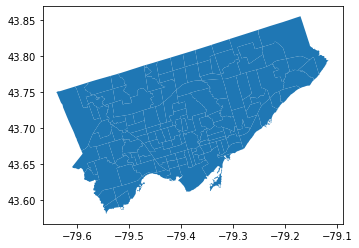

In [67]:
#load Toronto neighborhood boundary
# https://edu.hub.arcgis.com/datasets/edu::toronto-neighbourhoods-1/explore?location=43.717982%2C-79.377254%2C11.64
boundary_url = 'https://opendata.arcgis.com/api/v3/datasets/af06159170914808983959df6163fc86_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1'
toronto = gpd.read_file(boundary_url)

# Display the resulting GeoDataFrame
toronto.plot()

In [68]:
len(toronto)

140

In [70]:
# add a unique id that willl be usd to join the two data
toronto = toronto.sort_values(by ='Neighbourhood')
toronto['id_new'] = [i for i in range(1,141,1)]
toronto.head()

,OBJECTID,Neighbourhood,Total_Area,Total_Population,Pop_Males,Pop_Females,Pop0_4years,Pop5_9years,Pop10_14years,Pop15_19years,...,Language_Korean,Language_Persian,Language_Portuguese,Language_Russian,Language_Spanish,Language_Tagalog,Language_Tamil,Language_Urdu,geometry,id_new
79,80,Agincourt North,7.3,30280,14445,15845,1320,1345,1560,2000,...,55,140,70,20,145,780,2845,350,"POLYGON ((-79.24213 43.80247, -79.24319 43.802...",1
80,81,Agincourt South-Malvern West,7.9,21990,10630,11350,1080,930,1150,1480,...,70,170,60,25,130,500,1035,395,"POLYGON ((-79.25498 43.78122, -79.25797 43.780...",2
86,87,Alderwood,5.0,11900,5765,6130,610,495,555,650,...,40,20,425,190,160,260,15,10,"POLYGON ((-79.54866 43.59022, -79.54876 43.590...",3
56,57,Annex,2.8,29180,13745,15415,865,695,635,870,...,375,270,355,315,555,135,30,90,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",4
84,85,Banbury-Don Mills,10.0,26910,12485,14430,1180,1205,1325,1440,...,510,875,110,305,360,515,145,220,"POLYGON ((-79.33055 43.73979, -79.33044 43.739...",5


In [71]:
len(toronto)

140

In [72]:
# add a unique id that willl be usd to join the two data
data_ngbhd = demographic_data.iloc[1:,:]
data_ngbhd.rename(columns={'Characteristic':'Neighbourhood'}, inplace = True)
data_ngbhd['id_new'] = [i for i in range(1,141,1)]
data_ngbhd.head()

4,Neighbourhood,"Population, 2016",Youth (15-24 years),Total income: Average amount ($),Unemployment rate,Unemployment rate (Males),Working Age (25-54 years),id_new
1,Agincourt North,"29,113","3,705","30,414",9.8,9,"11,305",1
2,Agincourt South-Malvern West,"23,757","3,360","31,825",9.8,8.8,"9,965",2
3,Alderwood,"12,054","1,235","47,709",6.1,5.4,"5,220",3
4,Annex,"30,526","3,750","112,766",6.7,6.9,"15,040",4
5,Banbury-Don Mills,"27,695","2,730","67,757",7.2,6.4,"10,810",5


In [599]:
len(data_ngbhd)

140

In [600]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="olabanji_app")

# lat = []
# long = []

# for id, col in data_ngbhd.iterrows():
#     location = geolocator.geocode('Malvern West, Toronto Neighbourhood, Canada')
#     print(location)

# data_ngbhd["Latitude"] = lat
# data_ngbhd["Longitude"] = long


In [73]:
# merge the two data on the new id created
merge_toronto = toronto.merge(data_ngbhd, on='id_new')
merge_toronto.head()

,OBJECTID,Neighbourhood_x,Total_Area,Total_Population,Pop_Males,Pop_Females,Pop0_4years,Pop5_9years,Pop10_14years,Pop15_19years,...,Language_Urdu,geometry,id_new,Neighbourhood_y,"Population, 2016",Youth (15-24 years),Total income: Average amount ($),Unemployment rate,Unemployment rate (Males),Working Age (25-54 years)
0,80,Agincourt North,7.3,30280,14445,15845,1320,1345,1560,2000,...,350,"POLYGON ((-79.24213 43.80247, -79.24319 43.802...",1,Agincourt North,"29,113","3,705","30,414",9.8,9,"11,305"
1,81,Agincourt South-Malvern West,7.9,21990,10630,11350,1080,930,1150,1480,...,395,"POLYGON ((-79.25498 43.78122, -79.25797 43.780...",2,Agincourt South-Malvern West,"23,757","3,360","31,825",9.8,8.8,"9,965"
2,87,Alderwood,5.0,11900,5765,6130,610,495,555,650,...,10,"POLYGON ((-79.54866 43.59022, -79.54876 43.590...",3,Alderwood,"12,054","1,235","47,709",6.1,5.4,"5,220"
3,57,Annex,2.8,29180,13745,15415,865,695,635,870,...,90,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",4,Annex,"30,526","3,750","112,766",6.7,6.9,"15,040"
4,85,Banbury-Don Mills,10.0,26910,12485,14430,1180,1205,1325,1440,...,220,"POLYGON ((-79.33055 43.73979, -79.33044 43.739...",5,Banbury-Don Mills,"27,695","2,730","67,757",7.2,6.4,"10,810"


In [74]:
len(merge_toronto)

140

In [75]:
# drop other unwated data columns
toronto_nbhd = merge_toronto[['Neighbourhood_x', 'Population, 2016', 'Youth (15-24 years)',
                        'Total income: Average amount ($)',
                        'Unemployment rate','Unemployment rate (Males)','Working Age (25-54 years)','geometry'
                       ]]
toronto_nbhd

,Neighbourhood_x,"Population, 2016",Youth (15-24 years),Total income: Average amount ($),Unemployment rate,Unemployment rate (Males),Working Age (25-54 years),geometry
0,Agincourt North,"29,113","3,705","30,414",9.8,9,"11,305","POLYGON ((-79.24213 43.80247, -79.24319 43.802..."
1,Agincourt South-Malvern West,"23,757","3,360","31,825",9.8,8.8,"9,965","POLYGON ((-79.25498 43.78122, -79.25797 43.780..."
2,Alderwood,"12,054","1,235","47,709",6.1,5.4,"5,220","POLYGON ((-79.54866 43.59022, -79.54876 43.590..."
3,Annex,"30,526","3,750","112,766",6.7,6.9,"15,040","POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
4,Banbury-Don Mills,"27,695","2,730","67,757",7.2,6.4,"10,810","POLYGON ((-79.33055 43.73979, -79.33044 43.739..."
...,...,...,...,...,...,...,...,...
135,Wychwood,"14,349","1,320","54,460",5.2,5.7,"6,420","POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
136,Yonge-Eglinton,"11,817","1,225","89,330",6.9,5.5,"5,860","POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
137,Yonge-St.Clair,"12,528",920,"114,174",5.9,5.6,"5,960","POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
138,York University Heights,"27,593","4,750","29,958",10.7,9.9,"12,290","POLYGON ((-79.50529 43.75987, -79.50488 43.759..."


In [77]:
# check the columns info
toronto_nbhd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Neighbourhood_x                   140 non-null    object  
 1   Population, 2016                  140 non-null    object  
 2   Youth (15-24 years)               140 non-null    object  
 3   Total income: Average amount ($)  140 non-null    object  
 4   Unemployment rate                 140 non-null    object  
 5   Unemployment rate (Males)         140 non-null    object  
 6   Working Age (25-54 years)         140 non-null    object  
 7   geometry                          140 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 9.8+ KB


In [78]:
# fromat all columns
#Remove commas from the some column and convert the number to float
# In this example code, we use the str.replace() method to remove commas from the columns

toronto_nbhd['Population, 2016'] = toronto_nbhd['Population, 2016'].str.replace(',', '').astype(float)
toronto_nbhd['Youth (15-24 years)'] = toronto_nbhd['Youth (15-24 years)'].str.replace(',', '').astype(float)
toronto_nbhd['Total income: Average amount ($)'] = toronto_nbhd['Total income: Average amount ($)'].\
str.replace(',', '').astype(float)
toronto_nbhd['Unemployment rate'] = toronto_nbhd['Unemployment rate'].astype(float)
toronto_nbhd['Unemployment rate (Males)'] = toronto_nbhd['Unemployment rate (Males)'].astype(float)
toronto_nbhd['Working Age (25-54 years)'] = toronto_nbhd['Working Age (25-54 years)'].str.replace(',', '').astype(float)

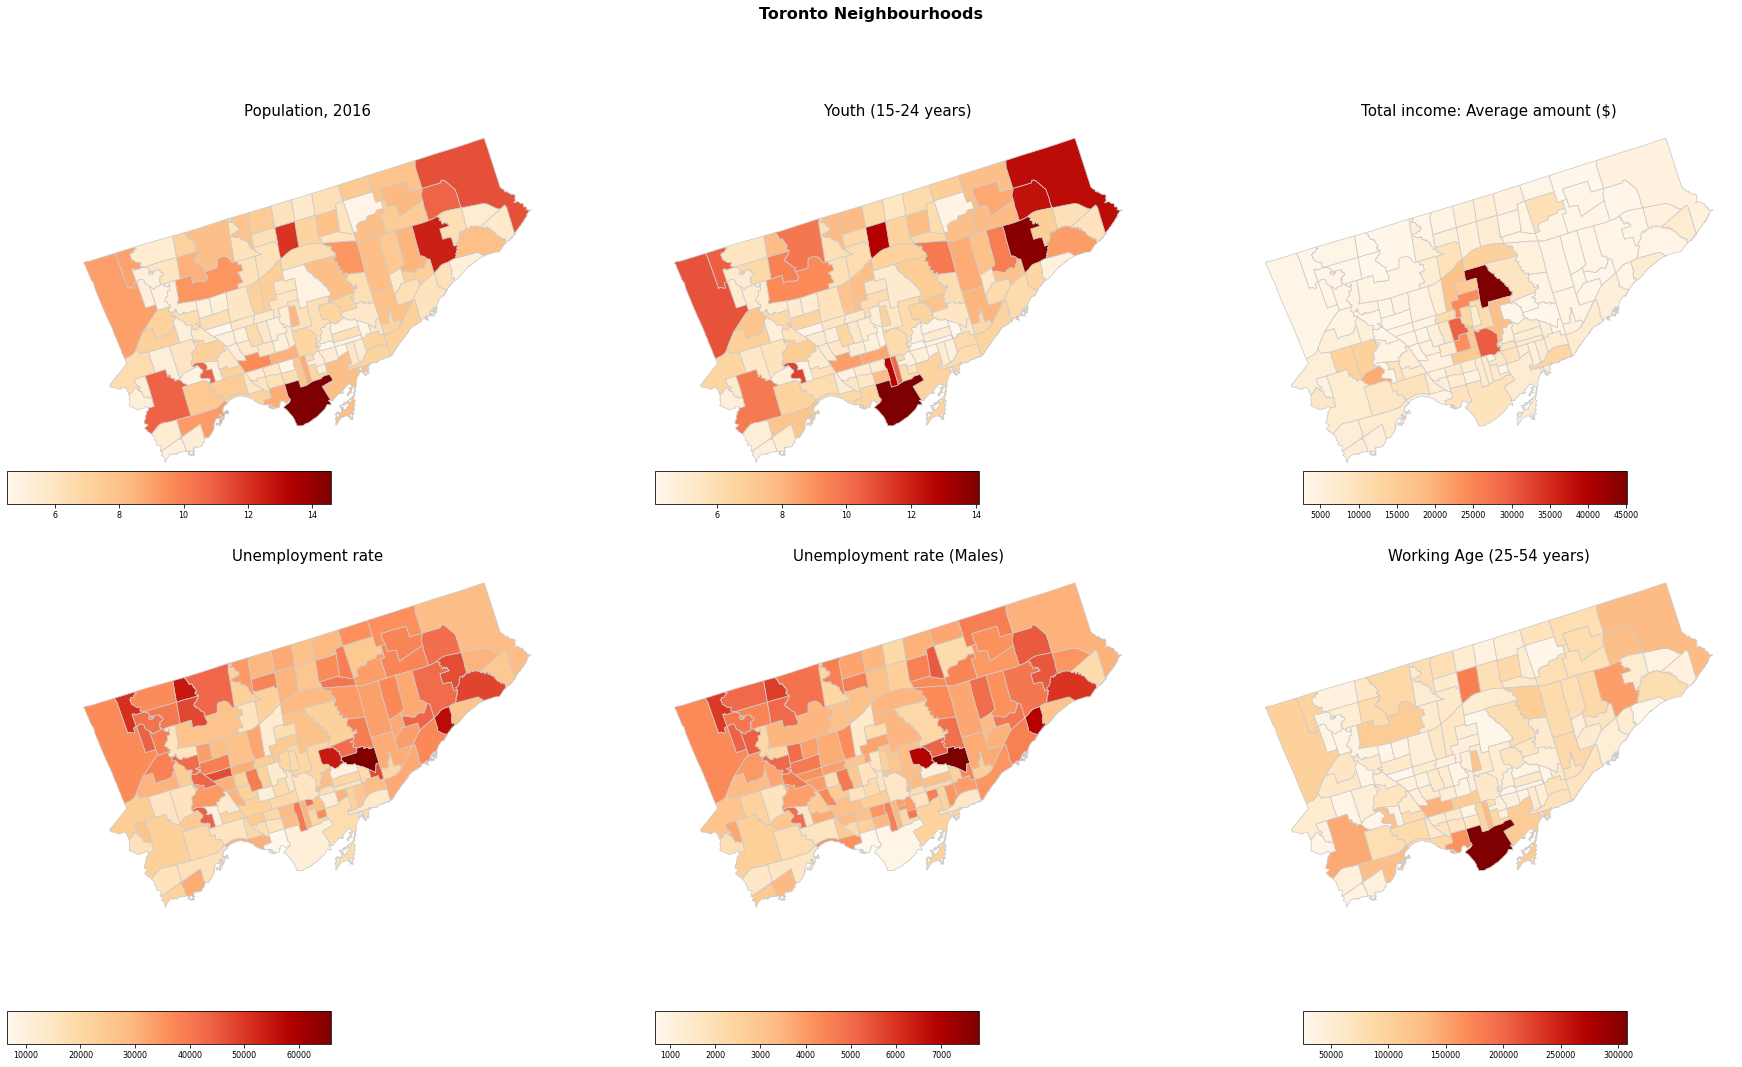

In [79]:
# Create choropleth map showing the distribution of the demographic and socio economic data in Toronto neighborhood
# Create the figure and the axes
fig, axs = plt.subplots(2, 3, figsize=(30, 15))

# Loop through each year and create a choropleth map in each subplot
for i, columns in enumerate(['Population, 2016', 'Youth (15-24 years)',
                        'Total income: Average amount ($)',
                        'Unemployment rate','Unemployment rate (Males)',
                            'Working Age (25-54 years)']):
    # Calculate the subplot coordinates
    row = i // 3
    col = i % 3

    # Create the choropleth map in the subplot
    toronto_nbhd.plot(column=columns, cmap='OrRd', linewidth=0.8, ax=axs[row, col], edgecolor='0.8')
    axs[row, col].axis('off')
    axs[row, col].set_title(columns, fontdict={'fontsize': '15', 'fontweight': '6'})
    
    
     # Add a legend to the subplot
    cax = fig.add_axes([0.1 + col * 0.3, 0.02 + row * 0.50, 0.15, 0.03])
    sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=toronto_nbhd[columns].min(), vmax=toronto_nbhd[columns].max()))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)

# Add a title to the entire figure
fig.suptitle('Toronto Neighbourhoods', fontsize=16, fontweight='bold')



# Show the figure
plt.show()

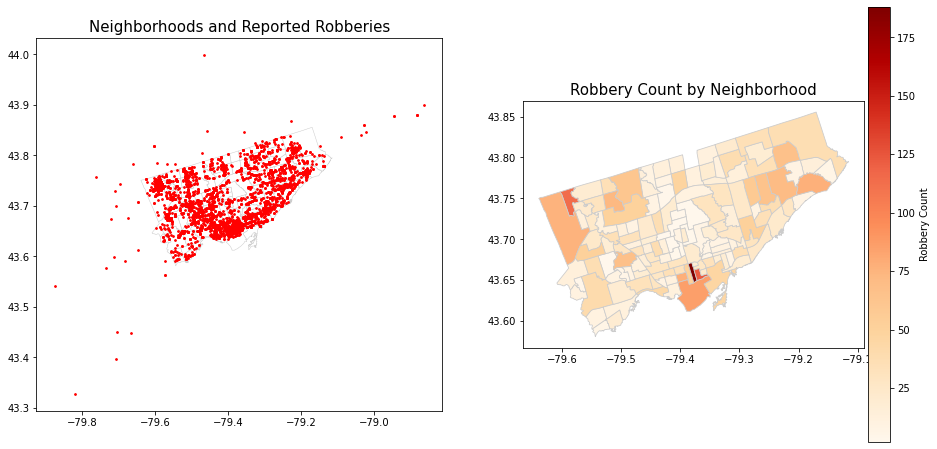

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1
toronto_nbhd.plot(linewidth=0.5, color='white', edgecolor='0.8', ax=axs[0])
robbery_gdf2.plot(ax=axs[0], markersize=3, color='red')

# Perform a spatial join between the point and polygon GeoDataFrames
aggregated = gpd.sjoin(robbery_gdf2, toronto_nbhd, how="left", op="within")

# Calculate the count of points within each polygon
count = aggregated.groupby("Neighbourhood_x").size()
count_df = pd.DataFrame(count)
robbery_count = count_df.rename(columns={0:'robbery count'}).reset_index()

# Join the count back to the polygon GeoDataFrame
toronto_nbhd = toronto_nbhd.merge(robbery_count, on='Neighbourhood_x')

toronto_nbhd.plot(column='robbery count', cmap='OrRd', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True,
                  legend_kwds={'label': "Robbery Count", 'orientation': "vertical", 'pad': 0.01})
# axs[0].axis('off')
# axs[1].axis('off')
axs[0].set_title('Neighborhoods and Reported Robberies', fontdict={'fontsize': '15', 'fontweight': '6'})
axs[1].set_title('Robbery Count by Neighborhood', fontdict={'fontsize': '15', 'fontweight': '6'})

plt.show()

In [81]:
toronto_nbhd

,Neighbourhood_x,"Population, 2016",Youth (15-24 years),Total income: Average amount ($),Unemployment rate,Unemployment rate (Males),Working Age (25-54 years),geometry,robbery count
0,Agincourt North,29113.0,3705.0,30414.0,9.8,9.0,11305.0,"POLYGON ((-79.24213 43.80247, -79.24319 43.802...",18
1,Agincourt South-Malvern West,23757.0,3360.0,31825.0,9.8,8.8,9965.0,"POLYGON ((-79.25498 43.78122, -79.25797 43.780...",35
2,Alderwood,12054.0,1235.0,47709.0,6.1,5.4,5220.0,"POLYGON ((-79.54866 43.59022, -79.54876 43.590...",10
3,Annex,30526.0,3750.0,112766.0,6.7,6.9,15040.0,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",29
4,Banbury-Don Mills,27695.0,2730.0,67757.0,7.2,6.4,10810.0,"POLYGON ((-79.33055 43.73979, -79.33044 43.739...",31
...,...,...,...,...,...,...,...,...,...
134,Wychwood,14349.0,1320.0,54460.0,5.2,5.7,6420.0,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",10
135,Yonge-Eglinton,11817.0,1225.0,89330.0,6.9,5.5,5860.0,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",8
136,Yonge-St.Clair,12528.0,920.0,114174.0,5.9,5.6,5960.0,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",3
137,York University Heights,27593.0,4750.0,29958.0,10.7,9.9,12290.0,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",62


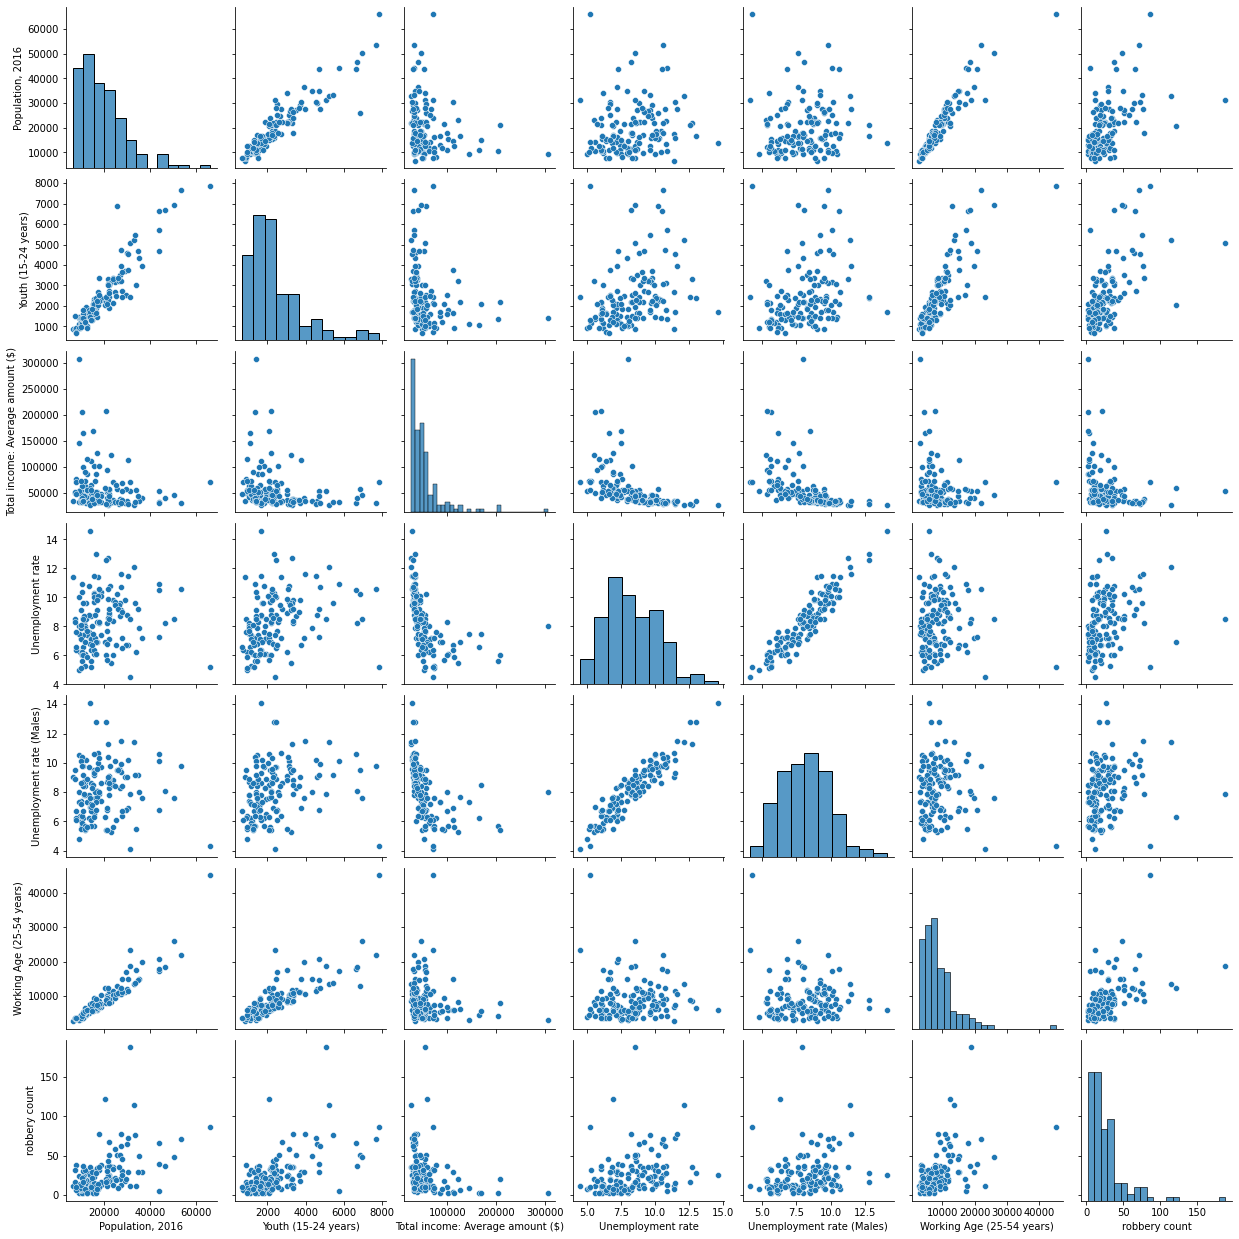

In [82]:
sns.pairplot(toronto_nbhd)

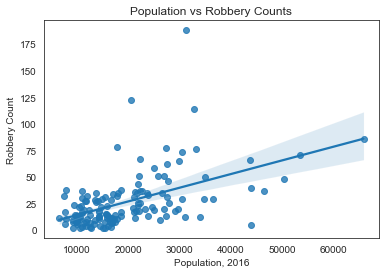

In [610]:
# Create a scatter plot with a regression line and confidence interval
sns.regplot(x='Population, 2016', y='robbery count', data=toronto_nbhd)

# Set the axis labels and title
plt.xlabel('Population, 2016')
plt.ylabel('Robbery Count')
plt.title('Population vs Robbery Counts')

# Display the plot
plt.show()

##### Findings
The provided dataset offers a glimpse into the demographic and economic landscape of six neighborhoods in an unspecified city, and the robbery crime rates of these areas. By analyzing this data, we can gain important insights into the socioeconomic characteristics of each neighborhood, as well as the factors that contribute to the prevalence of robbery crime.

One important finding is the correlation between high population and high robbery crime rates. The southern part of the Toronto neighborhood, which has the highest population, also has the highest rate of robbery crime. This suggests that robbery crime tends to occur more frequently in areas with a high concentration of people. Additionally, it appears that robbery crimes happen more often in areas with a high number of young people aged 15 to 24. This could be due to the fact that young people are more likely to be out and about in the evenings, and may be perceived as easier targets for criminals.

On the other hand, the central Toronto neighborhood has the lowest robbery crime rate. This is likely due to the fact that this neighborhood is comprised of people with high average incomes, who can afford security measures like cameras and guards. The data also shows that the unemployment rate is evenly distributed across the neighborhoods, except for central Toronto, where it is significantly lower. This could be a contributing factor to the higher average income rate in that area. The unemployment rate is higher for males than for females, and the neighborhoods with the highest robbery crime rates tend to have a lower unemployment rate, which suggests that medium income earners are more likely to be victims of robbery crime.

The working age data also shows that people between the ages of 35 and 54 are most likely to live in neighborhoods with high robbery crime rates. This is consistent with the finding that the neighborhoods with the highest crime rates tend to have a higher percentage of low-income earners.

By comparing the choropleth maps for population, youth, and robbery crime, we can visualize the relationship between these variables in each neighborhood. These insights can help inform policy decisions and resource allocation in order to address socioeconomic disparities and reduce crime rates in these neighborhoods. For instance, neighborhoods with high youth population may benefit from increased lighting and security measures in public spaces. Additionally, areas with high unemployment rates could benefit from targeted job training and employment programs to help reduce poverty and prevent crime. Overall, this data can provide important insights into the factors that contribute to crime rates, and can be used to inform policies and interventions aimed at reducing crime and promoting greater socioeconomic equality.

#### References

Rey, S. J., & Anselin, L. (2021). Point pattern analysis. Geographic Data Science, Chapter 8. Retrieved from https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html

Rey, S. J., & Pysal. (n.d.). Centrography. Pysal. Retrieved from https://github.com/pysal/pointpats/blob/9a09bd7ff2c3b5402f02a0a54175193cb643edd8/notebooks/centrography.ipynb

Darribas, I. (n.d.). Geovisualization with PySAL. Geographic Data Science, Lab 8. Retrieved from https://darribas.org/gds_course/content/bH/lab_H.html

PySAL Developers. (n.d.). Moran’s I visualization. PySAL. Retrieved from https://pysal.org/notebooks/viz/splot/esda_morans_viz.html

City of Toronto. (2016). Neighbourhood profiles. Open Data Catalogue. Retrieved from https://open.toronto.ca/dataset/neighbourhood-profiles/

ArcGIS Hub. (n.d.). Toronto neighbourhoods. ArcGIS Online. Retrieved from https://edu.hub.arcgis.com/datasets/edu::toronto-neighbourhoods-1/explore?location=43.717982%2C-79.377254%2C11.64

City of Toronto. (n.d.). Catalogue. Open Data Catalogue. Retrieved from https://open.toronto.ca/catalogue/
Toronto Police Service Open Data Portal. (n.d.). Retrieved from https://data.torontopolice.on.ca/